In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm
import pyfolio as pf
from tabulate import tabulate

C:\Users\cynthia.yapjy\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [67]:
stock_input = str(input("Please input stock: ")).upper()
tickers = stock_input.replace(' ','').split(',')
symbols = str(",".join(tickers))
print(symbols)

Please input stock: aapl,tsla
AAPL,TSLA


In [70]:
# limitations: tried it on stocks like BITO but no results, more mainstream ones like AAPL and TSLA is okay

import http.client, urllib.parse
import json

conn = http.client.HTTPSConnection('api.marketaux.com')

params = urllib.parse.urlencode({
    'api_token': 'rxj7tnU2c1AgEroBeiLIzuBrXOTR1mLD7pXTPjds',
    'symbols': symbols,
    'limit': 6,
    'language': 'en',
    })

conn.request('GET', '/v1/news/all?{}'.format(params))

res = conn.getresponse()
data = res.read()
data = data.decode('utf-8')
data = json.loads(data)
data = data['data']
for news in data:
#     print(news)
    news_title = news['title']
    sentiment_score = news['entities'][0]['sentiment_score']
    if sentiment_score == None:
        sentiment_score = 0
        sentiment = '(Neutral)'
    elif sentiment_score >= 0.1:
        sentiment = '(Positive)'
    elif sentiment_score <= -0.1:
        sentiment = '(Negative)'
    else:
        sentiment = '(Neutral)'
    source = news['source']
    sourcel_url = news['url']
    date_published = news['published_at'][:10]
    
    print('Title: ' + news_title)    
    print('Sentiment: ' + str(sentiment_score), sentiment)
    print('Source: ' + source)
    print('Source URL: ' + sourcel_url)
    print('Date Published: ' + date_published)
    print('')

Title: Richard Branson, Elon Musk Speak Up For Ukraine, Jeff Bezos Silent
Sentiment: 0.475433 (Positive)
Source: thestreet.com
Source URL: https://www.thestreet.com/investing/branson-musk-speak-up-for-ukraine-bezos-silent
Date Published: 2022-03-17

Title: Is Tesla (TSLA) A Smart Long-Term Buy?
Sentiment: 0.458143 (Positive)
Source: insidermonkey.com
Source URL: https://www.insidermonkey.com/blog/is-tesla-tsla-a-smart-long-term-buy-2-1033454/
Date Published: 2022-03-17

Title: Futures slip on Ukraine jitters after Fed-driven rally By Reuters
Sentiment: -0.0516 (Neutral)
Source: investing.com
Source URL: https://www.investing.com/news/economy/futures-slip-on-ukraine-jitters-after-feddriven-rally-2786610
Date Published: 2022-03-17



In [33]:
print((data['data'][0]['entities'][0]['sentiment_score']))

0.274789


## Finding the Efficient Frontier using Monte Carlo simulations

In [39]:
from pandas_datareader import data
import numpy as np
import pandas as pd

In [42]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ['FB', 'TSLA', 'TWTR', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

n_assets = len(RISKY_ASSETS)

In [43]:
prices_df = data.DataReader(RISKY_ASSETS,'yahoo', START_DATE, END_DATE)

Symbols,FB,MSFT,TSLA,TWTR
count,253.000000,253.000000,253.000000,253.000000
mean,320.976482,274.163607,779.700709,59.968656
std,34.915458,37.456935,160.965509,8.706164
min,245.639999,210.051315,563.000000,42.070000
25%,298.660004,241.820267,668.059998,53.540001
50%,329.220001,275.406342,729.770020,62.099998
75%,344.459991,300.657135,849.989990,66.949997
max,382.179993,342.402008,1229.910034,77.629997


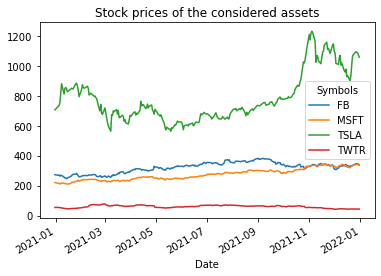

In [44]:
prices_df['Adj Close'].plot(title='Stock prices of the considered assets');

In [45]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

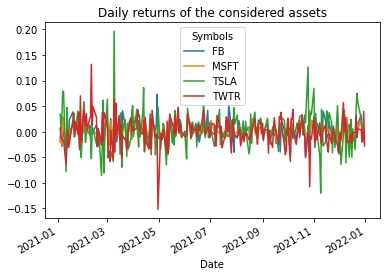

In [46]:
returns_df.plot(title='Daily returns of the considered assets');

In [47]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [48]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

portf_weights = []
for portfolio in weights:
    string = ''
    for weight in portfolio:
        weight = round(weight * 100,1)
        string += str(weight) + '%, '
    portf_weights.append(string[:len(string)-2])
    

In [65]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})
portf_results_df.head()

,returns,volatility,sharpe_ratio
0,0.32,0.266399,1.193358
1,0.02,0.346430,0.071715
2,0.15,0.268279,0.574021
3,0.27,0.258164,1.046230
4,0.33,0.264733,1.243458


In [63]:
portf_results_df_test = pd.DataFrame({'weights': portf_weights,
                                 'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

    

In [64]:
portf_results_df_test.head()

,weights,returns,volatility,sharpe_ratio
0,"14.1%, 35.8%, 27.6%, 22.5%",0.32,0.266399,1.193358
1,"12.6%, 12.6%, 4.7%, 70.1%",0.02,0.346430,0.071715
2,"26.1%, 30.8%, 0.9%, 42.2%",0.15,0.268279,0.574021
3,"59.0%, 15.1%, 12.9%, 13.0%",0.27,0.258164,1.046230
4,"19.6%, 33.8%, 27.8%, 18.8%",0.33,0.264733,1.243458


In [50]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

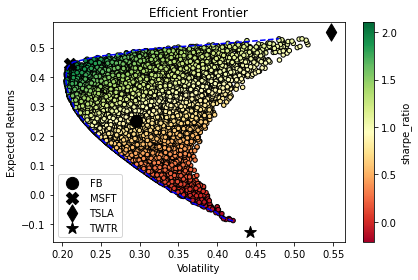

In [51]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
# plt.savefig('images/efficient_frontier_1.png')
plt.show()

In [53]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)


Maximum Sharpe Ratio portfolio ----
Performance
returns: 44.03% volatility: 20.94% sharpe_ratio: 210.27% 
Weights
FB: 2.60% MSFT: 95.17% TSLA: 2.04% TWTR: 0.19% 

In [54]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)
    

Minimum Volatility portfolio ----
Performance
returns: 38.67% volatility: 20.46% sharpe_ratio: 188.99% 
Weights
FB: 17.35% MSFT: 78.16% TSLA: 0.23% TWTR: 4.26% 

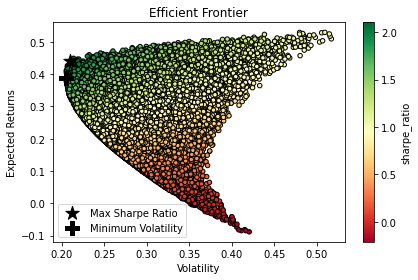

In [55]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
# plt.savefig('images/ch7_im11.png')
plt.show()

## Simulating stock price dynamics using Geometric Brownian Motion

In [101]:
from pandas_datareader import data
import numpy as np
import pandas as pd

RISKY_ASSET = 'AAPL'
START_DATE = '2021-01-01'
END_DATE = '2022-03-16'

df = data.DataReader(RISKY_ASSET,'yahoo', START_DATE, END_DATE)

adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

In [102]:
train = returns['2021-01-01':'2022-03-16']

In [103]:
T = 30
N = 30
S_0 = adj_close[train.index[-1]]
N_SIM = 100
mu = train.mean()
sigma = train.std()

In [104]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):

    np.random.seed(random_seed)
    
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps 
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

In [105]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

In [108]:
# prepare objects for plotting 
last_train_date = train.index[-1].date()
# first_test_date = test.index[0].date()
# last_test_date = test.index[-1].date()
# plot_title = (f'{RISKY_ASSET} Simulation '
#               f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.show()

KeyError: datetime.date(2021, 12, 31)